# ⭐**Dynamic Chat Agents**


## Table of Contents

- [***1. Introduction to Graph-Based Chatbots***](#1-introduction-to-graph-based-chatbots)
- [***2. Building an Agent with LangGraph***](#2-building-an-agent-with-langgraph)
- [***3. Streaming Responses***](#3-streaming-responses)
- [***4. Adding External Tools***](#4-adding-external-tools)
- [***5. Adding Memory***](#5-adding-memory)


In [1]:
# Setup cell: Importing all necessary modules

# Typing tools for annotations and custom data structures
from typing import Annotated
from typing_extensions import TypedDict

# Core LangGraph components for building agentic workflows
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Language model provider (Groq via LangChain)
from langchain_groq import ChatGroq  

# Wikipedia integration: API wrapper and LangChain tool
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

# Prebuilt tool-handling utilities and conditional logic for tool execution
from langgraph.prebuilt import ToolNode, tools_condition

# IPython utility to display images in Jupyter notebooks
from IPython.display import Image, display

# In-memory checkpointing for LangGraph agent state (useful for debugging)
from langgraph.checkpoint.memory import MemorySaver

# Load environment variables from a `.env` file (e.g., for API keys)
from dotenv import load_dotenv
load_dotenv()

True


## 1. Introduction to Graph-Based Chatbots

LangGraph enables the construction of agentic chatbots by defining workflows as stateful graphs.

### Key Concepts

- **Graph State**: Controls tool usage and the order of execution.
- **Agent State**: Tracks the task completion and maintains conversation history.
- **Nodes**: `Functions` or `tool` calls.
- **Edges**: Rules that direct the graph from one node to another.
- Pre-built nodes include `START` and ``END`.

- 📌 *Think of a graph as a map of decisions or steps a chatbot takes when responding to user input.*


## 2. Building an Agent with LangGraph

We define a language model, a state type, and initialize the LangGraph system.

### Define the LLM and State


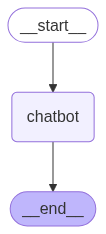

In [2]:
# Initialize the language model
llm = ChatGroq(model="llama-3.1-8b-instant")

# State is a custom TypedDict used to define the shape of data passed between nodes in the graph
# - It contains a single key: messages, which holds a list of messages exchanged (human/AI)
# - The Annotated[..., add_messages] tells LangGraph how to automatically merge or accumulate messages during execution
class State(TypedDict):
    messages: Annotated[list, add_messages] # Messages with metadata

# Create graph builder with State structure
graph_builder = StateGraph(State)

# Core function: generate chatbot response based on current state
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Define graph flow: START -> chatbot -> END
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile and visualize the graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


## 3. Streaming LLM responses

- LangGraph supports streaming responses which allow for real-time feedback.

- **Streaming LLM responses** refers to the process of **receiving and displaying the output from a language model (LLM) as it is being generated**, rather than waiting for the full response to be completed before showing anything.



### 🔄 Traditional (Non-Streaming) vs. Streaming

| Mode          | Behavior                                                              | Example                             |
| ------------- | --------------------------------------------------------------------- | ----------------------------------- |
| Non-Streaming | Waits for the LLM to finish generating the full output                | Text appears all at once            |
| Streaming     | Shows output **token-by-token** (or chunk-by-chunk) as it's generated | Text appears gradually, like typing |


### 📦 Why Use Streaming?

1. **Faster Feedback:** The user sees partial output immediately, improving perceived speed.
2. **Interactive UX:** Feels more natural and conversational, like someone typing live.
3. **Useful for Long Responses:** Especially helpful when generating paragraphs or code.
4. **Real-time Control:** Allows interruption, cancellation, or even redirection mid-generation.


In [3]:
# ──────────────────────────────────────────────────────────────────────────────
# Define a function to stream responses from the graph (chatbot) in real time
# ──────────────────────────────────────────────────────────────────────────────

# Function to execute the chatbot and stream updates as they're generated
def stream_graph_updates(user_input: str): 
    # Start streaming events from the graph using the user's input
    for event in graph.stream({"messages": [("user", user_input)]}): 
        # Each event contains updates from graph nodes
        for value in event.values():
            # Print the latest response from the agent (message content)
            print("Agent:", value["messages"]) 


# Example usage: 
user_query = "Who is Mary Shelley?" 
stream_graph_updates(user_query)


Agent: [AIMessage(content='Mary Shelley (1797-1851) was a British novelist, best known for writing the famous Gothic novel "Frankenstein; or, The Modern Prometheus." Born August 30, 1797, in London, England, Mary Shelley was the daughter of philosopher and writer William Godwin and his wife, the pioneering feminist Mary Wollstonecraft.\n\nMary Shelley\'s life was marked by both personal struggles and literary achievements. She married the poet Percy Bysshe Shelley in 1814, but their relationship was tumultuous. After her husband\'s death in a sailing accident in 1822, Mary Shelley was left to raise their son alone.\n\nDuring her time in Switzerland with Percy Bysshe Shelley, Mary Shelley was inspired by the surrounding landscape and the conversations of their friends, including Lord Byron and John William Polidori. It was during this time that she began writing "Frankenstein," which was first published anonymously in 1818.\n\n"Frankenstein" tells the story of Victor Frankenstein, a sci

### ✅ What this does:
- Accepts a user_input string.
- Streams the LLM’s response in real-time, using graph.stream(...).
- As each graph node emits a value (e.g., the chatbot), it prints the generated message(s) from the agent.


## 4. Adding external Tools to a chatbot

- LangGraph supports integration with tools such as Wikipedia, enabling the agent to look up factual information in real time. 
- Tools allow the chatbot to extend its capabilities beyond just language modeling, by connecting it to external services or APIs

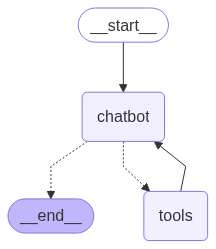

In [4]:

# ----------------------------------------------------
# 🌟 Set up Wikipedia Tool and Integrate with Chatbot
# ----------------------------------------------------

# Initialize the Wikipedia API wrapper (limit results to top 1 for relevance)
api_wrapper = WikipediaAPIWrapper(top_k_results=1)

# Wrap the Wikipedia API as a LangChain-compatible tool
wikipedia_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

# Add the Wikipedia tool to the tools list (can include multiple tools)
tools = [wikipedia_tool]

# Bind the tools to the LLM
# This lets the LLM know which tools it can call during a conversation
llm_with_tools = llm.bind_tools(tools)

# Update the chatbot function to use the LLM with tool binding
# This enables dynamic tool invocation based on user input (e.g., triggering a Wikipedia lookup)
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# -------------------------------------------------------------------
# 🟢 Define the Chatbot and Tool Nodes with Conditional Tool Routing
# -------------------------------------------------------------------

# Create a new graph builder with the defined State structure
graph_builder = StateGraph(State)

# # Add chatbot node to the graph 
graph_builder.add_node("chatbot", chatbot)

# Create a ToolNode to handle tool calls and add it to the graph 
tool_node = ToolNode(tools=[wikipedia_tool])
graph_builder.add_node("tools", tool_node)

# -------------------------------------------------------------------
# 🟢 Define the graph edges and routing logic
# -------------------------------------------------------------------

# Set up a condition to direct from chatbot to tool or end node
graph_builder.add_conditional_edges("chatbot", tools_condition)

# Connect tools back to chatbot and   
# add START and END nodes 
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


# Compile Visualize the compiled graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## 5. Adding memory and conversation

LangGraph can persist conversations using memory modules.

### Configure Memory

In [9]:
# --- Modify the graph with memory checkpointing ---
memory = MemorySaver()  # Initialize memory saver to store conversation state

# Compile the graph with memory as the checkpointing backend
graph = graph_builder.compile(checkpointer=memory)

# --- Set up a streaming function for a single user session ---
def stream_memory_responses(user_input: str):
    # Config with a static thread_id to retain memory over the session
    config = {"configurable": {"thread_id": "single_session_memory"}}
    
    # Stream events through the graph with the user input
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        
        # Print agent's response from the event values
        for value in event.values():
            if "messages" in value and value["messages"]:
                print("Agent:", value["messages"])

# --- Simulate an interactive conversation ---
stream_memory_responses("Tell me about the Eiffel Tower.")
stream_memory_responses("Who built it?")

Agent: [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5j1wskfgp', 'function': {'arguments': '{"query":"Eiffel Tower"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 290, 'total_tokens': 307, 'completion_time': 0.029237399, 'prompt_time': 0.017251333, 'queue_time': 0.050781826999999995, 'total_time': 0.046488732}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9c605227-7f55-44bb-a432-d47238cfc7bf-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Eiffel Tower'}, 'id': '5j1wskfgp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 290, 'output_tokens': 17, 'total_tokens': 307})]
Agent: [ToolMessage(content='Page: Eiffel Tower\nSummary: The Eiffel Tower (  EYE-fəl; French: Tour Eiffel [tuʁ ɛfɛl] ) is a wrought-iron lattice tower on the Champ de Mars in Paris, France. I

# -----------------------------------------------------------------------
# 💡**Chatbots with LangGraph: A Comprehensive Study Guide**

# -----------------------------------------------------------------------

### 1. What is the primary purpose of a "Graph State" in LangGraph, and how does it contribute to chatbot functionality?

**Answer:**
>The primary purpose of a "Graph State" is to organize different tasks within a chatbot's workflow. It manages elements like tool use, LLM calls, and the overall order of operations, essentially defining the chatbot's internal process.

---

### 2. How does an "Agent State" differ from a "Graph State," and what specific information does it track within a LangGraph chatbot?

**Answer:**
>An "Agent State" specifically tracks the agent's progress throughout the conversation. It logs task completion and internal states, providing a detailed record of what the agent has done and where it is in a multi-step process.

---

### 3. Define "nodes" and "edges" within the context of LangGraph. What role do they play in structuring a chatbot's workflow?

**Answer:**
>"Nodes" in LangGraph represent functions or actions that the chatbot can perform, such as generating a response or making a tool call. "Edges" are rules that define the connections and flow between these nodes, dictating the sequence of tasks.

---

### 4. Explain the function of the `add_node` and `add_edge` methods when building a LangGraph.

**Answer:**
>The `add_node` method is used to define and incorporate a specific function or action (like the chatbot function) into the graph. The `add_edge` method establishes a directional connection between two nodes, determining the path of execution.

---

### 5. What is the significance of the START and END nodes in LangGraph, and how are they typically used?

**Answer:**
>START and END nodes are pre-built components in LangGraph that define the beginning and conclusion of a conversation flow. START initiates the graph's execution, while END signifies that the graph has reached a terminal state for that particular turn.

---

### 6. Describe the process of streaming graph events and its benefit for monitoring a chatbot's operation.

**Answer:**
>Streaming graph events involves retrieving and printing the chatbot's node responses and workflow steps in real-time. This allows developers to track responses, tool calls, and overall chatbot progress as the conversation unfolds.

---

### 7. What is an "LLM hallucination," and why is it important to be aware of this phenomenon when designing chatbots?

**Answer:**
>An "LLM hallucination" refers to instances where a Large Language Model generates information that is factually incorrect or nonsensical, despite sounding plausible. It's crucial to be aware of this to design systems that verify information or mitigate such occurrences.

---

### 8. How are external tools, such as a Wikipedia API, integrated into a LangGraph chatbot, and what is the role of `llm.bind_tools`?

**Answer:**
>External tools are integrated by first initializing the tool (e.g., `WikipediaAPIWrapper`) and then binding it to the language model using `llm.bind_tools`. This enables the LLM to decide when and how to call these external functions based on the user's query.

---

### 9. Explain the purpose of a `ToolNode` in LangGraph and how `tools_condition` is used in conjunction with it.

**Answer:**
>A `ToolNode` in LangGraph is a specific type of node designed to handle tool calls, directing the workflow to execute the appropriate external function. `tools_condition` acts as a conditional edge, determining whether the chatbot should transition to a `ToolNode` or proceed to an END node based on the LLM's decision to use a tool.

---

### 10. How is memory implemented in a LangGraph chatbot, and what advantage does it provide for ongoing conversations?

**Answer:**
>Memory is implemented in LangGraph by using modules like `MemorySaver` and compiling the graph with a checkpointer. This allows the chatbot to retain information from previous turns in a conversation, enabling it to respond coherently to follow-up questions without needing explicit re-contextualization.



## **II. Glossary of Key Terms**

* **Agent State**: A component within LangGraph that tracks the progress and logs the completion of tasks performed by the chatbot agent. It helps maintain context and understand where the agent is in a multi-step workflow.

* **Chatbot Construction**: The process of assembling the various components (nodes, edges, states) to create a functional conversational agent using LangGraph.

* **Edges**: Rules or connections within a LangGraph that define the flow and transitions between different nodes. They dictate the order in which tasks or actions are executed.

* **Graph State**: A central data structure in LangGraph that organizes different tasks, manages tool use, handles LLM calls, and defines the overall order of operations (workflow) for the chatbot.

* **LangGraph**: A framework for building robust and stateful multi-actor applications with LLMs, particularly useful for designing complex chatbot workflows.

* **LLM Calls**: Instances where the chatbot interacts with a Large Language Model (LLM) to generate responses, understand user input, or make decisions.

* **LLM Hallucinations**: A phenomenon where a Large Language Model generates factually incorrect, misleading, or nonsensical information, often presented as if it were true.

* **Memory (in LangGraph)**: The capability of a LangGraph chatbot to retain and recall information from previous turns in a conversation, allowing for more coherent and contextual interactions. Implemented using checkpointers like `MemorySaver`.

* **Nodes**: Represent individual functions, tasks, or actions within a LangGraph workflow. These can include generating responses, calling external tools, or processing data.

* **StateGraph**: A LangGraph module used to define the structure of the graph, allowing for the addition of nodes and edges to build the chatbot's workflow.

* **stream()**: A method in LangGraph used to execute the graph and receive events (workflow steps, responses, tool calls) in real-time as they occur.

* **START and END nodes**: Pre-built nodes in LangGraph that mark the beginning and conclusion of a graph's execution for a given conversational turn or task.

* **ToolNode**: A specific type of node in LangGraph designed to handle the execution of external tools. When the LLM decides to use a tool, the workflow can be directed to a `ToolNode`.

* **tools\_condition**: A conditional edge in LangGraph that directs the flow of the graph based on whether the LLM decides to call a tool or not. It determines if the next step should be a `ToolNode` or another part of the graph (e.g., END).

* **Workflow Management**: The process of organizing and controlling the sequence of tasks and interactions within a chatbot, often defined by the nodes and edges of a LangGraph.

